# DANA Indonesia Digital Wallet: Sentiment Analysis

In this project We'll be using NLP algorithm to predict the sentiment on [DANA's](https://play.google.com/store/apps/details?id=id.dana) review, regardless of the app version or the review period,  we'll use the most relevant review from google play scaper.
I include clear step-by-step machine learning pipeline on crafting model such as data gathering, data cleaning, data preprocessing, feature extraction, modeling, evaluation, etc.
The label we use here are based on Lexicon analysis in which generate 3 difference label Positive, Negative, and Neutral. I employed Class Weight method for dealing with imabalance data.
The NLP we employ here are LSTM combined with various of Feature Extraction methods, including Word Embedding using Word2Vector and TF-IDF.

Before continue with this file, we should gather all the data we need in from file [data_scraping.ipynb](data_scraping.ipynb)

# Libraries

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import LSTM, Embedding, Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

2025-02-08 21:58:31.783658: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-08 21:58:31.795322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739023111.809579   25611 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739023111.813773   25611 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-08 21:58:31.827842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
import gensim
from keras.optimizers import Adam
from keras.layers import Bidirectional, Input
from keras.regularizers import l2
import pickle

# Feature Extraction

In [12]:
final_df = pd.read_csv('final_df.csv')

In [13]:
final_df.head(3)

,content,case_folding,clean_text,normal_slang,filtered_stop_word,tokenized_text,stemmed_word,polarity_score,polarity,final_text
0,"Bisa ngga sih dana upgrade lagi, bila pembayar...","bisa ngga sih dana upgrade lagi, bila pembayar...",bisa ngga sih dana upgrade lagi bila pembayara...,bisa enggak sih dana upgrade lagi bila pembaya...,enggak dana upgrade bila pembayaran otomatis l...,"['enggak', 'dana', 'upgrade', 'bila', 'pembaya...","['enggak', 'dana', 'upgrade', 'bila', 'bayar',...",-4,negative,enggak dana upgrade bila bayar otomatis langga...
1,"Payah...kenapa membuat cemas,membuat kecewa mi...","payah...kenapa membuat cemas,membuat kecewa mi...",payah kenapa membuat cemas membuat kecewa mitr...,payah kenapa membuat cemas membuat kecewa mitr...,payah cemas membuat kecewa mitramu aplikasi bi...,"['payah', 'cemas', 'membuat', 'kecewa', 'mitra...","['payah', 'cemas', 'buat', 'kecewa', 'mitra', ...",-21,negative,payah cemas buat kecewa mitra aplikasi bisa bu...
2,Saya mau upgrade ke premium tapi selalu muncul...,saya mau upgrade ke premium tapi selalu muncul...,saya mau upgrade ke premium tapi selalu muncul...,saya mau upgrade ke premium tapi selalu muncul...,upgrade premium selalu muncul keterangan gagal...,"['upgrade', 'premium', 'selalu', 'muncul', 'ke...","['upgrade', 'premium', 'selalu', 'muncul', 'te...",-3,negative,upgrade premium selalu muncul terang gagal tim...


## Features and Labels Splitting

In [14]:
Y_data = final_df['polarity'].reset_index(drop=True)
X_data_sntnc = final_df['final_text'].apply(lambda x: np.str_(x))#sntnc for sentence

X ,x_test, Y, y_test = train_test_split(X_data_sntnc, Y_data, test_size=0.1, stratify=Y_data)#90/10

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, stratify=Y)


## Computing Class Weight for Data imbalance

### Encoding the Y

In [15]:
Y_data_encd = LabelEncoder().fit_transform(Y_data)

In [33]:
with open('label_encoded.pkl', 'wb') as handle:# wb for write binary
    pickle.dump(Y_data_encd, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
classes = np.unique(Y_data_encd)#getting unique classes in Y data
classes

array([0, 1, 2])

### Compute Class Weight

In [17]:
classweight = compute_class_weight(y=Y_data_encd, class_weight='balanced', classes=classes)#use the entire Y data(no split data) to compute the class weight
classweight

array([0.59521311, 7.21736099, 0.8464715 ])

In [18]:
classweight = dict(zip(classes, classweight))#combine
classweight

{0: 0.5952131100409689, 1: 7.217360990064494, 2: 0.8464715021669801}

## Feature Extraction Word Embedding with Word2Vector

### Train w2v model with dataset

converting sentences into token and train w2v model

In [29]:
X_data_tw = X_data_sntnc.apply(lambda x: gensim.utils.simple_preprocess(np.str_(x)))
X_data_tw

0         [enggak, dana, upgrade, bila, bayar, otomatis,...
1         [payah, cemas, buat, kecewa, mitra, aplikasi, ...
2         [upgrade, premium, selalu, muncul, terang, gag...
3         [untuk, cs, bot, video, tutor, update, jalan, ...
4         [adalah, aplikasi, walet, baik, saya, bantu, t...
                                ...                        
124213    [mantap, kalo, tingkat, dengan, beli, saldo, g...
124214    [aplikasi, tipu, uang, gajih, di, dana, beku, ...
124215    [dana, aplikasi, sangat, bagus, saya, dari, da...
124216             [kesini, jelek, aplikasi, suka, lag, di]
124217    [kontl, dana, saldo, potong, alas, potong, lan...
Name: final_text, Length: 124218, dtype: object

In [30]:
wv_model = Word2Vec(sentences=X_data_tw, window=10, min_count=2, workers=4)

In [31]:
wv_model.save('w2v_3.model')

In [32]:
wv_model = Word2Vec.load('w2v_3.model')

### Encoding The Polarity

In [33]:
le = LabelEncoder()

In [34]:
y_train_wv_encd = le.fit_transform(y_train)

In [35]:
y_val_wv_encd = le.transform(y_val)

In [36]:
y_test_wv_encd = le.transform(y_test)

In [37]:
np.unique(y_train_wv_encd)

array([0, 1, 2])

### Tokenizer

In [20]:
print(x_train.shape)
print(y_train.shape)

(89436,)
(89436,)


In [38]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_data_sntnc)

In [39]:
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_val_sequences = tokenizer.texts_to_sequences(x_val)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

In [24]:
#Save the token for inference
with open('wv_tokenizer.pkl', 'wb') as handle:# wb for write binary
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Word Embedding

In [40]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
vocab_size
word_index.items()

dict_items([('<OOV>', 1), ('dana', 2), ('aplikasi', 3), ('saldo', 4), ('bisa', 5), ('di', 6), ('enggak', 7), ('masuk', 8), ('transaksi', 9), ('saya', 10), ('ada', 11), ('pakai', 12), ('sudah', 13), ('uang', 14), ('tidak', 15), ('akun', 16), ('baik', 17), ('banget', 18), ('apk', 19), ('premium', 20), ('update', 21), ('bagus', 22), ('bantu', 23), ('kali', 24), ('buka', 25), ('kirim', 26), ('hilang', 27), ('kecewa', 28), ('transfer', 29), ('mau', 30), ('kalo', 31), ('top', 32), ('guna', 33), ('mudah', 34), ('bayar', 35), ('yang', 36), ('ini', 37), ('upgrade', 38), ('login', 39), ('pulsa', 40), ('susah', 41), ('kasih', 42), ('aman', 43), ('mohon', 44), ('sangat', 45), ('saja', 46), ('suruh', 47), ('pas', 48), ('gagal', 49), ('coba', 50), ('beli', 51), ('cs', 52), ('tunggu', 53), ('jadi', 54), ('jaring', 55), ('isi', 56), ('jelas', 57), ('belum', 58), ('cepat', 59), ('potong', 60), ('hasil', 61), ('email', 62), ('lama', 63), ('sekarang', 64), ('baru', 65), ('apa', 66), ('tapi', 67), ('nomor

In [41]:
embedding_matrix = np.zeros(shape=(vocab_size,wv_model.vector_size))
for word, i in word_index.items():
    if word in wv_model.wv:
        embedding_matrix[i] = wv_model.wv[word]


In [42]:
embedding_matrix.size

3843200

### Padding Data X

In [43]:
len_pad = [len(sentence) for sentence in x_train_sequences]

In [44]:
print(f"max {np.max(len_pad)}")
print(f'mean {np.mean(len_pad)}')
print(f'99% {np.percentile(len_pad,99)}')

max 83
mean 18.06390044277472
99% 52.0


In [16]:
max_len_w2v = 52

In [45]:
x_train_wv_pad = pad_sequences(sequences=x_train_sequences, maxlen=max_len_w2v, truncating='post', padding='post')
x_val_wv_pad = pad_sequences(sequences=x_val_sequences, maxlen=max_len_w2v, truncating='post', padding='post')
x_test_wv_pad = pad_sequences(sequences=x_test_sequences, maxlen=max_len_w2v, truncating='post', padding='post')

In [46]:
print(x_train_wv_pad.shape)
print(y_train_wv_encd.shape)

(89436, 52)
(89436,)


## Feature Extraction with TF-IDF

### Vectorize Data X

In [19]:
tfidf = TfidfVectorizer(max_features=5000, min_df=100)
x_train_vec = tfidf.fit_transform(x_train)
x_val_vec = tfidf.transform(x_val)
x_test_vec = tfidf.transform(x_test)

In [20]:
x_train_tfidf = x_train_vec.toarray()
x_val_tfidf = x_val_vec.toarray()
x_test_tfidf = x_test_vec.toarray()


In [29]:
with open('tfidf_vectorizer.pkl', 'wb') as handle:
    pickle.dump(tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Reshape dimension

In [21]:
X_train_tfidf_reshaped = np.reshape(x_train_tfidf, (x_train_tfidf.shape[0], 1, x_train_tfidf.shape[1]))
X_val_tfidf_reshaped = np.reshape(x_val_tfidf, (x_val_tfidf.shape[0], 1, x_val_tfidf.shape[1]))
X_test_tfidf_reshaped = np.reshape(x_test_tfidf, (x_test_tfidf.shape[0], 1, x_test_tfidf.shape[1]))

### Encode Data Y

In [22]:
le2 = LabelEncoder()
y_train_tfidf_encd = le2.fit_transform(y_train)
y_val_tfidf_encd = le2.transform(y_val)
y_test_tfidf_encd = le2.transform(y_test)

In [23]:
print(X_train_tfidf_reshaped.shape)
print(y_train_tfidf_encd.shape)

(89436, 1, 1017)
(89436,)


# Modeling

## Callback

In [37]:
checkpoint_dir = './checkpoints_'

def callback(dir_type, patience_es, patience_rl):
    cp_dir = checkpoint_dir+dir_type
    filepath=cp_dir + "/model_{epoch:02d}_{val_loss:.2f}.keras"

    earlystop = EarlyStopping(monitor='val_loss', patience=patience_es, restore_best_weights=True)# the training will stop when reaching 6 epochs with no improvement
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=patience_rl, factor=0.45, min_lr=1e-7)# after 3 epoch of no improvement learning rate will be change. min_lr 1e-7 is the lower point where the LR will not be change
    model_cp = ModelCheckpoint(filepath=filepath, monitor='val_loss',save_best_only=True,save_weights_only=False,verbose=1,save_freq='epoch')
    tensor_board = TensorBoard(log_dir=cp_dir+'/logs/',histogram_freq=1)
    callbacks=[earlystop, reduce_lr, model_cp, tensor_board]
    return callbacks

In [25]:
def the_adam ():
    return Adam( learning_rate=1e-3,
    weight_decay=1e-4,  # Global weight decay instead of per-layer L2
    global_clipnorm=1.0  # Gradient clipping)
)

## LSTM + Word2Vector

### Model

In [40]:
lstm_wv_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=wv_model.vector_size, weights=embedding_matrix, trainable=False),
    Bidirectional(LSTM(128,return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(1e-5))),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(1e-5))),
    BatchNormalization(),
    Dense(256, activation='swish'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

I0000 00:00:1738864042.533206    3916 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2795 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


### Compile

In [42]:
lstm_wv_model.compile(loss='sparse_categorical_crossentropy', optimizer=the_adam(), metrics=['accuracy'])
lstm_wv_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,843,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,843,200 (14.66 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,843,200 (14.66 MB)

### Training

In [100]:
lstm_wv_model.fit(x_train_wv_pad, y_train_wv_encd, validation_data=(x_val_wv_pad, y_val_wv_encd), class_weight=classweight, callbacks=callback(dir_type='w2v', patience_es=7, patience_rl=3), epochs=50, batch_size=40)

Epoch 1/50
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6567 - loss: 1.0034
Epoch 1: val_loss improved from inf to 0.50731, saving model to ./checkpoints_w2v/model_01_0.51.keras
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 197s 85ms/step - accuracy: 0.6567 - loss: 1.0033 - val_accuracy: 0.7920 - val_loss: 0.5073 - learning_rate: 0.0010
Epoch 2/50
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7428 - loss: 0.7855
Epoch 2: val_loss improved from 0.50731 to 0.48382, saving model to ./checkpoints_w2v/model_02_0.48.keras
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 193s 86ms/step - accuracy: 0.7428 - loss: 0.7855 - val_accuracy: 0.7839 - val_loss: 0.4838 - learning_rate: 0.0010
Epoch 3/50
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7770 - loss: 0.7222
Epoch 3: val_loss improved from 0.48382 to 0.43442, saving model to ./checkpoints_w2v/model_03_0.43.keras
2236/2236 ━━━━━━━━━━━━━━━━━━━━ 214s 96ms/step - accuracy: 0.7770 - loss: 0.7222 - val_accuracy: 0.8205 - val_loss: 0.4344 - lea

### Save Last model

In [101]:
lstm_wv_model.save(checkpoint_dir+"w2v/model_last.keras")

## LSTM + TF-IDF

### Model

In [33]:
lstm_tfidf_model = Sequential([
    Input(shape=(X_train_tfidf_reshaped.shape[1], X_train_tfidf_reshaped.shape[2])),
    Bidirectional(LSTM(256,return_sequences=True, dropout=0.15, recurrent_dropout=0.15, kernel_regularizer=l2(1e-5))),
    Bidirectional(LSTM(256, dropout=0.15, recurrent_dropout=0.15, kernel_regularizer=l2(1e-5))),
    BatchNormalization(),
    Dense(256, activation='swish'),
    Dense(128, activation='relu'),
    Dropout(0.15),
    Dense(3, activation='softmax')
])

### Compile

In [34]:
lstm_tfidf_model.compile(optimizer=the_adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_tfidf_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 1, 512)         │     2,609,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,350,723 (16.60 MB)

 Trainable params: 4,349,699 (16.59 MB)

 Non-trainable params: 1,024 (4.00 KB)

### Training

In [38]:
lstm_tfidf_model.fit(X_train_tfidf_reshaped, y_train_tfidf_encd, validation_data=(X_val_tfidf_reshaped, y_val_tfidf_encd), class_weight=classweight, callbacks=callback(dir_type='tfidf', patience_es=7, patience_rl=3), epochs=50, batch_size=50)

Epoch 1/50
1786/1789 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8618 - loss: 0.5005
Epoch 1: val_loss improved from inf to 0.34322, saving model to ./checkpoints_tfidf/model_01_0.34.keras
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.8618 - loss: 0.5005 - val_accuracy: 0.8779 - val_loss: 0.3432 - learning_rate: 1.8453e-05
Epoch 2/50
1786/1789 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8610 - loss: 0.5005
Epoch 2: val_loss improved from 0.34322 to 0.34128, saving model to ./checkpoints_tfidf/model_02_0.34.keras
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.8610 - loss: 0.5004 - val_accuracy: 0.8784 - val_loss: 0.3413 - learning_rate: 1.8453e-05
Epoch 3/50
1786/1789 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8647 - loss: 0.4787
Epoch 3: val_loss did not improve from 0.34128
1789/1789 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.8647 - loss: 0.4787 - val_accuracy: 0.8784 - val_loss: 0.3423 - learning_rate: 1.8453e-05
Epoch 4/50
1788/1789 ━━━━━━

### Save last model

In [39]:
lstm_tfidf_model.save(checkpoint_dir+"tfidf/model_last.keras")

# Model Evaluation

### LSTM + Word2Vector

In [40]:
lstm_wv_model_test = load_model('checkpoints_w2v/model_last.keras')

In [ ]:
y_pred_wv = lstm_wv_model_test.predict(x_test_wv_pad)

In [48]:
y_pred_labels_wv = np.argmax(y_pred_wv, axis=1)

In [49]:
accuracy_wv = accuracy_score(y_test_wv_encd, y_pred_labels_wv)
print(f"Accuracy: {accuracy_wv}")

print(classification_report(y_test_wv_encd, y_pred_labels_wv))

cm_wv = confusion_matrix(y_test_wv_encd, y_pred_labels_wv)
print("Confusion Matrix:\n", cm_wv)

Accuracy: 0.9194976654322975
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      6956
           1       0.42      0.81      0.55       574
           2       0.96      0.93      0.94      4892

    accuracy                           0.92     12422
   macro avg       0.78      0.89      0.81     12422
weighted avg       0.94      0.92      0.93     12422

Confusion Matrix:
 [[6426  382  148]
 [  51  466   57]
 [  95  267 4530]]


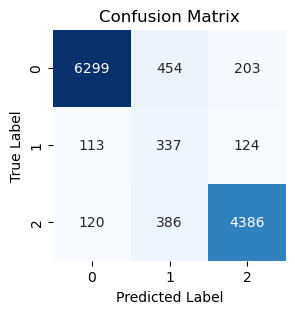

In [110]:
plt.figure(figsize=(3, 3))
sns.heatmap(cm_wv, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### LSTM + TF-IDF

In [42]:
lstm_tfidf_model_ = load_model('checkpoints_tfidf/model_last.keras')

In [43]:
X_test_tfidf_reshaped.shape

(12422, 1, 1017)

In [44]:
y_pred_tfidf = lstm_tfidf_model_.predict(X_test_tfidf_reshaped)

389/389 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [45]:
y_pred_labels_tfidf = np.argmax(y_pred_tfidf, axis=1)

In [46]:
accuracy_tfidf = accuracy_score(y_test_tfidf_encd, y_pred_labels_tfidf)
print(f'Accuracy: {accuracy_tfidf}')

Accuracy: 0.8872967316052166


In [47]:
print(classification_report(y_test_tfidf_encd, y_pred_labels_tfidf))

              precision    recall  f1-score   support

           0       0.98      0.89      0.94      6956
           1       0.29      0.81      0.43       574
           2       0.97      0.89      0.92      4892

    accuracy                           0.89     12422
   macro avg       0.75      0.86      0.76     12422
weighted avg       0.94      0.89      0.91     12422



In [48]:
cm_tfidf = confusion_matrix(y_test_tfidf_encd, y_pred_labels_tfidf)
print(cm_tfidf)

[[6225  635   96]
 [  51  466   57]
 [  53  508 4331]]


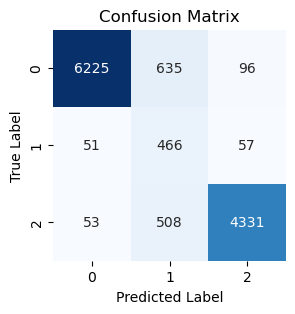

In [49]:
plt.figure(figsize=(3, 3))
sns.heatmap(cm_tfidf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Inference

In [50]:
from prep_helper import text_cleaner, text_stemmer, stop_word_filter, to_sentence

I am taking random comment on internet for inference

In [51]:
# New data
new_data = [["Akhir² ini Vainglory lagi panas-panasnya dengan pembaruan2 yg menurut saya terbilang wahh untuk jagad moba android, tapi dengan pembaruan yg terus-menerus size nya semakin tidak bersahabat dengan hp kentang dengan storage kecil, pasti kamu kecewa para user potato phone gak bisa main VG lagi dan imbasnya sekarang ramai orang bilang VG ini dead Gim, menurut saya sih kagak ya cuma di Indonesia aja terlihat mati but di server lain masih rame"],
              ["Metode aplikasi ini hampir sama dengan Apktool tapi apktool memerlukan akses root, agar bisa mengekstrak smali nya harus upgrade ke versi pro dulu :)"],
              ["Terimakasih arif brata, pekan lalu suruh kompas pasang mic di penonton, jadi ketawa nya real, terasa meriahnya, terasa gerr nya, pokoknya show terbaik sejauh ini disuci 11, dan banyak kejutan, semua terhibur. 🎉🎉🎉🎉"],
              ["saya kurang setuju bahwa encrypt di frontend kurang berguna, karena bisa menggunakan sistem public dan private key, dimana data di FE di encrypt menggunakan kunci public yang disediakan oleh BE, sehingga hanya BE lah yang bisa men decrypt data dari FE. dan apabila ada MITM attack, mereka pun tidak bisa membaca pesan/data tersebut karena tidak punya kunci private nya. Ini terutama apabila data dikirim dijaringan yang kurang aman."],
              ["Kenapa aku baru nemu akun ini ya? Sumpah buka mindset semua videonya. Makasih ya ko 🙏🏻"],
              ["Pasti awalnya yang punya ace ini ganti nama jadi AZ karena ingin org2 bacanya Eis karena menghindari tuntuan atas nama yg mirip makanya dibuat pake AZ, kalau KO nya mungkin dari co (corporate) ya. Seperti Jco atau Mako"]
              ]

new_data = pd.DataFrame(new_data)
new_data

,0
0,Akhir² ini Vainglory lagi panas-panasnya denga...
1,Metode aplikasi ini hampir sama dengan Apktool...
2,"Terimakasih arif brata, pekan lalu suruh kompa..."
3,saya kurang setuju bahwa encrypt di frontend k...
4,Kenapa aku baru nemu akun ini ya? Sumpah buka ...
5,Pasti awalnya yang punya ace ini ganti nama ja...


### Word2Vec

In [91]:
def inference_wv(iterable, text=' '):
    if not iterable:
         text = input("Input the text :")

    print(f"Your input:{text}")
    new_data_x = text_cleaner(text)
    new_data_x = stop_word_filter(new_data_x)
    new_data_x_final = [text_stemmer(gensim.utils.simple_preprocess(np.str_(new_data_x)))]
    print(new_data_x_final)
    #create new tokenizer from save model
    new_token = Tokenizer()
    #Load saved tokenizer
    with open('wv_tokenizer.pkl', 'rb') as handle:#rb for read binary
        new_token = pickle.load(handle)
    #Create data sequences
    new_data_sequence = new_token.texts_to_sequences(new_data_x_final)
    new_data_pad = pad_sequences(sequences=new_data_sequence, maxlen=52, truncating='post', padding='post')
    label = LabelEncoder()
    with open('label_encoded.pkl', 'rb') as handle:# wb for write binary
            label = pickle.load(handle)
    #run the prediction
    lstm_wv_model_inference = load_model('checkpoints_w2v/model_last.keras')
    inference_y = lstm_wv_model_inference.predict(new_data_pad)
    inference_result_label = np.argmax(inference_y, axis=-1)
    #to label
    class_label = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    reverse_label_map = {v: k for k, v in class_label.items()}  #create the reverse mapping key adn value
    label_result = [reverse_label_map[label] for label in inference_result_label]

    print(f"Sentiment result: {label_result[0]}")
    print('_____________________________________________________________')

Run inference with manual input

In [77]:
inference_wv(iterable=False)

Your input:Kenapa aku baru nemu akun ini ya? Sumpah buka mindset semua videonya. Makasih ya ko 🙏🏻"
[['kenapa', 'baru', 'nemu', 'akun', 'sumpah', 'buka', 'mindset', 'video', 'makasih', 'ya', 'ko']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
Sentiment result: Positive
_____________________________________________________________


Run inference from iterable data

In [78]:
new_data[0].apply(lambda x: inference_wv(iterable=True, text=x))

Your input:Akhir² ini Vainglory lagi panas-panasnya dengan pembaruan2 yg menurut saya terbilang wahh untuk jagad moba android, tapi dengan pembaruan yg terus-menerus size nya semakin tidak bersahabat dengan hp kentang dengan storage kecil, pasti kamu kecewa para user potato phone gak bisa main VG lagi dan imbasnya sekarang ramai orang bilang VG ini dead Gim, menurut saya sih kagak ya cuma di Indonesia aja terlihat mati but di server lain masih rame
[['akhir', 'vainglory', 'panas', 'panas', 'baru', 'yg', 'saya', 'bilang', 'wahh', 'jagad', 'moba', 'android', 'baru', 'yg', 'terus', 'size', 'makin', 'sahabat', 'hp', 'kentang', 'dengan', 'storage', 'pasti', 'kecewa', 'user', 'potato', 'phone', 'bisa', 'main', 'vg', 'dan', 'imbas', 'ramai', 'orang', 'bilang', 'vg', 'dead', 'gim', 'saya', 'kagak', 'cuma', 'indonesia', 'aja', 'mati', 'di', 'server', 'masih', 'rame']]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
Sentiment result: Negative
_____________________________________________________________


0    None
1    None
2    None
3    None
4    None
5    None
Name: 0, dtype: object

### TF-IDF

In [68]:
def inference_tfidf(iterable, text=' '):
    if not iterable:
         text = input("Input the text :")
    print(f"Your input:{text}")
    new_data_x = text_cleaner(text)
    new_data_x = stop_word_filter(new_data_x)
    new_data_x_stem_token = [text_stemmer(gensim.utils.simple_preprocess(np.str_(new_data_x)))]
    new_data_x_final = [to_sentence(data)for data in new_data_x_stem_token]
    print(new_data_x_final)
    #create new Vectorizer from save model
    new_vetoctorizer = TfidfVectorizer()
    with open('tfidf_vectorizer.pkl', 'rb') as handle:#rb for read binary
        new_vetoctorizer = pickle.load(handle)
    x_data_vector = new_vetoctorizer.transform(new_data_x_final)
    x_data_tfidf = x_data_vector.toarray()
    x_data_tfidf_reshape = np.reshape(x_data_tfidf, (x_data_tfidf.shape[0], 1, x_data_tfidf.shape[1]))
    
    #Prediction
    new_tfidf_model = load_model('checkpoints_tfidf/model_last.keras')
    y_data_tfidf = new_tfidf_model.predict(x_data_tfidf_reshape)
    y_data_label_result = np.argmax(y_data_tfidf, axis=-1)

    #to label
    class_label = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
    reverse_label_map = {v: k for k, v in class_label.items()}  #create the reverse mapping key adn value
    label_result = [reverse_label_map[label] for label in y_data_label_result]
    print(f"Sentiment result: {label_result[0]}")
    print('_____________________________________________________________')

    

In [69]:
inference_tfidf(iterable=False)

Your input:["Terimakasih arif brata, pekan lalu suruh kompas pasang mic di penonton, jadi ketawa nya real, terasa meriahnya, terasa gerr nya, pokoknya show terbaik sejauh ini disuci 11, dan banyak kejutan, semua terhibur. 🎉🎉🎉🎉"],
['terimakasih arif brata pekan suruh kompas pasang mic tonton ketawa real riah gerr pokok show baik ini suci banyak kejut hibur']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Sentiment result: Positive
_____________________________________________________________


In [70]:
for data in new_data[0]:
    inference_tfidf(iterable=True, text=data)

Your input:Akhir² ini Vainglory lagi panas-panasnya dengan pembaruan2 yg menurut saya terbilang wahh untuk jagad moba android, tapi dengan pembaruan yg terus-menerus size nya semakin tidak bersahabat dengan hp kentang dengan storage kecil, pasti kamu kecewa para user potato phone gak bisa main VG lagi dan imbasnya sekarang ramai orang bilang VG ini dead Gim, menurut saya sih kagak ya cuma di Indonesia aja terlihat mati but di server lain masih rame
['akhir vainglory panas panas baru yg saya bilang wahh jagad moba android baru yg terus size makin sahabat hp kentang dengan storage pasti kecewa user potato phone bisa main vg dan imbas ramai orang bilang vg dead gim saya kagak cuma indonesia aja mati di server masih rame']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Sentiment result: Negative
_____________________________________________________________
Your input:Metode aplikasi ini hampir sama dengan Apktool tapi apktool memerlukan akses root, agar bisa mengekstrak smali nya harus upgrade ke ver

# Conclusions

Training with data imbalance sure something that we need to avoid, but with class weight it does really help. Compareing feature extraction method turned out verry joyful, alot of article says that TF-IDF might not the best match with LSTM, in the training, validation, and test accuracy it did, but the fact that TF-IDF can detect Neutral sentiment from inference data([new_data]) it really suprising. In the contraray, Word2VecFrom the number 1 LSTM's besties showing ovefitting pattern. In the training time TF-IDF much more faster than Word2Vec. Surely Word2Vec have potential with this case because the training accuracy can get to 90%.